In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
warnings.filterwarnings('ignore')

In [136]:
# SNPs
folder = 'samtovcf/new/'
SNP=pd.read_csv('%s/model.sum..txt'%(folder), sep='\t')
SNP['Genome']=[x.split('.')[0] for x in SNP['sample']]

if 'covid' in folder:
    SNP['total_refSNP'] = [float(x.split('.fasta.')[1].split('.')[0]) for x in SNP['sample']]
    SNP['total SNPs'] = [int(x) for x in SNP['total_refSNP']]
    SNP['Tool']=[x.split('.fasta.')[2].split('.flt')[0].split('.vcf')[0] for x in SNP['sample']]
    SNP['tooldetauls'] = [x.split('.fasta.')[2] for x in SNP['sample']]
else:
    SNP['total_refSNP'] = [float(x.split('.corrected.')[1].split('.')[0]) for x in SNP['sample']]
    SNP['Tool']=[x.split('SNP.fasta.')[1].split('.flt')[0].split('.vcf')[0] for x in SNP['sample']]
    SNP['tooldetauls'] = [x.split('SNP.fasta.')[1] for x in SNP['sample']]
    ref_snp = pd.read_csv('%s/../ref_snp.txt'%(folder),sep='\t',header=None)
    ref_snp.columns=['total SNPs','sample']
    ref_snp['total SNPs'] = [int(x) for x in ref_snp['total SNPs']]
    SNP['sample'] = [x.split('.SNP.fasta')[0] + '.SNP.fasta.snp.txt' for x in SNP['sample']]
    SNP = SNP.merge(ref_snp,left_on = 'sample',right_on = 'sample',how = 'left')
    
print(SNP['Tool'].unique())
SNP['VCF caller'] = ''
SNP['VCF caller']=[x.replace('bowtie','').replace('minimap','').replace('bwa','').replace('.mappersamtovcf','Variant identifier').replace('.bcfdefault','bcftools default') for x in SNP['Tool']]
SNP['VCF caller']=[x.replace('Variant identifier','VCFer') for x in SNP['VCF caller']]
SNP.loc[SNP['Tool'].isin(['bowtie','bwa','minimap']),'VCF caller'] = 'bcftools'
SNP['Tool'] = [x.split('.')[0].replace('bowtie','bowtie2').replace('minimap','minimap2') for x in SNP['Tool']]
# filter by duplicate kmers > 10000
SNP = SNP[~SNP['Genome'].isin(['am_BaFr_gS1T203',
                               'H20_BA_g0002',
                               'P63_BA_01','an_EsCo_g0001','cx_BaTh_g0001',
                               'bq_BaTh_g0001'])]
genome_set = {'am_BA_g0003':'BiAd',
                 'am_BaFr_g0050':'BaFr',
                 'am_BaSa_g0015':'BaSa',
             'am_AkMu_g0002':'AkMu','am_BaOv_g0001':'BaOv',
              'am_BaVu_g0002':'BaVu','am_EsCo_g0005':'EsCo',
             'am_PaDi_g0001':'PaDi','SRR2842672':'human',
             'aa_BaFa_g0001':'BaFa-aa','bf_BaFa_g0001':'BaFa',
              'bj_EsCo_g0001':'EsCo','cx_BaXy_g0001':'BaXy','SRR10971381':'SARS-COV-2'}

SNP['Genome'] = [genome_set.get(x,x) for x in SNP['Genome']]
SNP['FPrate']=SNP['FP']/SNP['total SNPs']
SNP['FNrate']=SNP['FN']/SNP['total SNPs']
allgenome = SNP['Genome'].unique()
print(allgenome)
SNP['Tool VCF caller'] = SNP['Tool'] + '-' + SNP['VCF caller']
SNP = SNP.sort_values(['Genome','Tool','VCF caller','total_refSNP'])
SNP=SNP[SNP['total_refSNP']!=0]
print(SNP['Tool'].unique(),SNP['VCF caller'].unique())
SNP.head()


['minimap.bcfdefault' 'bwa' 'bowtie' 'bowtie.bcfdefault' 'minimap'
 'bwa.bcfdefault' 'bowtie.mappersamtovcf' 'minimap.mappersamtovcf'
 'bwa.mappersamtovcf']
['AkMu' 'BiAd' 'BaFr' 'BaOv' 'BaVu' 'PaDi' 'BaFa' 'EsCo' 'BaXy']
['bowtie2' 'bwa' 'minimap2'] ['VCFer' 'bcftools' 'bcftools default']


,sample,FP,FN,total_refSNP,Genome,Tool,tooldetauls,total SNPs,VCF caller,FPrate,FNrate,Tool VCF caller
44,am_AkMu_g0002.fasta.corrected.1e-06.SNP.fasta....,7,0,0.000001,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,24,VCFer,0.291667,0.000000,bowtie2-VCFer
72,am_AkMu_g0002.fasta.corrected.2e-06.SNP.fasta....,0,0,0.000002,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,24,VCFer,0.000000,0.000000,bowtie2-VCFer
100,am_AkMu_g0002.fasta.corrected.3e-06.SNP.fasta....,0,0,0.000003,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,27,VCFer,0.000000,0.000000,bowtie2-VCFer
123,am_AkMu_g0002.fasta.corrected.4e-06.SNP.fasta....,0,0,0.000004,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,29,VCFer,0.000000,0.000000,bowtie2-VCFer
164,am_AkMu_g0002.fasta.corrected.5e-06.SNP.fasta....,0,1,0.000005,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,30,VCFer,0.000000,0.033333,bowtie2-VCFer


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


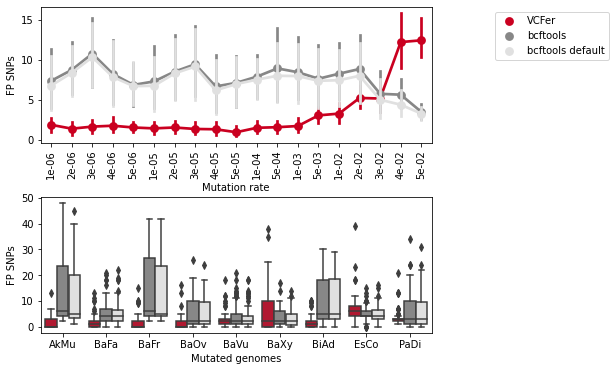

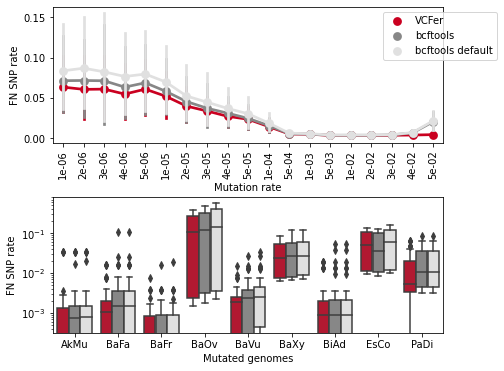

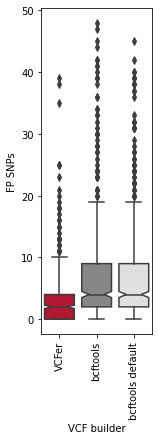

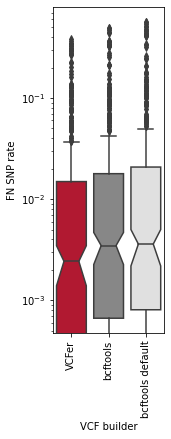

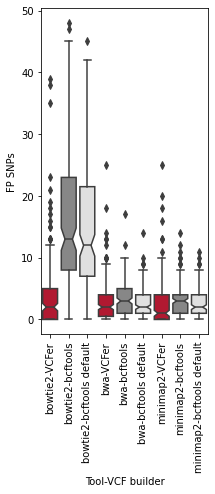

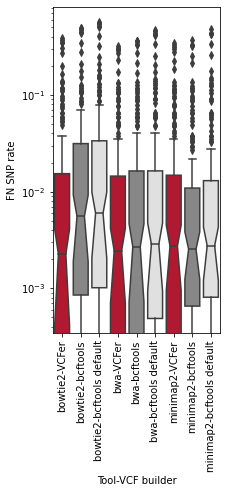

In [137]:
# plot FP
pallete_set = {
        'VCFer':'#ca0020','bcftools':'#878787','bcftools default':'#e0e0e0'}


for genome in allgenome:
    SNPsub = SNP[SNP['Genome']==genome]
# plot FN sum for mutations and genomes
if 'covid' not in folder:
    SNP['total_refSNP']=['%.0e'%(x) for x in SNP['total_refSNP']]
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)
    sns.pointplot(x='total_refSNP', y='FP', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FP SNPs')
    plt.sca(axs[0])
    plt.legend(bbox_to_anchor=(1.15, 1.0))
    sns.boxplot(x='Genome', y='FP', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FP SNPs')
    axs[1].get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 3a.pdf'%(folder),bbox_inches='tight')
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)
    sns.pointplot(x='total_refSNP', y='FNrate', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FN SNP rate')
    #axs[0].set(yscale="log")
    plt.sca(axs[0])
    plt.legend(bbox_to_anchor=(1.15, 1.0))
    sns.boxplot(x='Genome', y='FNrate', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FN SNP rate')
    axs[1].set(yscale="log")
    axs[1].get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 3b.eps'%(folder),bbox_inches='tight',format='eps')
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette = pallete_set)
    axs.set_xlabel('VCF builder') 
    axs.set_ylabel('FP SNPs')
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    #plt.sca(axs)
    #plt.legend(bbox_to_anchor=(1.15, 1.0))
    plt.savefig('%s/Figure 3c.pdf'%(folder),bbox_inches='tight')
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FNrate', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('VCF builder') 
    axs.set_ylabel('FN SNP rate')
    axs.set(yscale="log")
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    plt.savefig('%s/Figure 3d.eps'%(folder),bbox_inches='tight',format='eps')
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette = pallete_set)
    axs.set_xlabel('Tool-VCF builder') 
    axs.set_ylabel('FP SNPs')
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    #plt.sca(axs)
    #plt.legend(bbox_to_anchor=(1.15, 1.0))
    plt.savefig('%s/Figure S3a.pdf'%(folder),bbox_inches='tight')
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FNrate', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Tool-VCF builder') 
    axs.set_ylabel('FN SNP rate')
    axs.set(yscale="log")
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    plt.savefig('%s/Figure S3b.eps'%(folder),bbox_inches='tight',format='eps')
else:
    # plot FP
    SNP['FPrate'] = SNP['FP']/SNP['total_refSNP']
    SNP['FNrate'] = SNP['FN']/SNP['total_refSNP']
    SNP = SNP[SNP['total_refSNP']!=0]
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.2)
    sns.boxplot(x='VCF caller', y='FP',notch = True,  data=SNP,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('VCF builder') 
    axs[0].set_ylabel('FP SNPs')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FP', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FP SNPs')
    plt.sca(axs[1])
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 4c.pdf'%(folder),bbox_inches='tight')

    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.2)
    sns.boxplot(x='VCF caller', y='FN',notch = True,  data=SNP,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('VCF builder') 
    axs[0].set_ylabel('FN SNPs')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FN', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FN SNPs')
    plt.sca(axs[1])
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 4d.eps'%(folder),bbox_inches='tight',format='eps')


In [138]:
# MO
SNPspecies = pd.DataFrame(SNP.groupby(['total_refSNP','VCF caller'])['FNrate'].median())
SNPspecies.reset_index(inplace=True)
print(kstest(SNPspecies.loc[SNPspecies['VCF caller']=='VCFer','FNrate'],
      SNPspecies.loc[SNPspecies['VCF caller']=='bcftools','FNrate'])
)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,np.quantile(SNPspeciessub['FNrate'],[0.05,0.5,0.95]),np.mean(SNPspeciessub['FNrate']),np.std(SNPspeciessub['FNrate']))
    

KstestResult(statistic=0.3157894736842105, pvalue=0.3056890512159651)
VCFer [0.         0.00216294 0.01750656] 0.0051330888637731 0.007914566637177654
bcftools [0.         0.00348432 0.01750656] 0.0065049043038105875 0.0076786416106892266
bcftools default [0.         0.00348432 0.01750656] 0.00687263425121356 0.0077625034868144495


In [139]:
# MO
SNPspecies = pd.DataFrame(SNP.groupby(['total_refSNP','VCF caller'])['FP'].median())
SNPspecies.reset_index(inplace=True)
print(kstest(SNPspecies.loc[SNPspecies['VCF caller']=='VCFer','FP'],
      SNPspecies.loc[SNPspecies['VCF caller']=='bcftools','FP'])
)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,np.quantile(SNPspeciessub['FP'],[0.05,0.5,0.95]),np.mean(SNPspeciessub['FP']),np.std(SNPspeciessub['FP']))
    

KstestResult(statistic=0.6842105263157895, pvalue=0.00015621221647240893)
VCFer [0.  1.  9.1] 2.0 2.772040859423935
bcftools [2.  4.  5.2] 4.157894736842105 1.0888505718724841
bcftools default [2.  4.  5.2] 4.0 1.2139539573337679


In [125]:
# MO
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools','FNrate'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools','FNrate'])
)

KstestResult(statistic=0.3180932128300549, pvalue=3.5677144607647953e-23)
KstestResult(statistic=0.07013999645578593, pvalue=0.15725654520091803)
KstestResult(statistic=0.046464646464646465, pvalue=0.6597462147725583)
KstestResult(statistic=0.04040404040404041, pvalue=0.8144149365006678)


In [83]:
# MO
print(sum(SNP.loc[SNP['VCF caller']=='bcftools','FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FP']),
      sum(SNP.loc[SNP['VCF caller']=='bcftools','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FN']),
      sum(SNP.loc[SNP['VCF caller']=='bcftools default','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='bcftools','FN'])
     )
print('FP',np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)


2.293040293040293 2.5826359832635983 1.0627697426584268
FP [ 0.   2.  12.4] [ 0.   4.  29.3] [ 0.   4.  26.3]
FNrate [ 0.          0.24245674 13.33297367] [ 0.          0.34674863 13.67088608] [ 0.          0.35911814 17.5443038 ]


In [78]:
SNP['total_refSNP'].unique()

array(['1e-06', '2e-06', '3e-06', '4e-06', '5e-06', '1e-05', '2e-05',
       '3e-05', '4e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03',
       '1e-02', '2e-02', '3e-02', '4e-02', '5e-02'], dtype=object)

In [124]:
# MO
SNPsub = SNP[SNP['total_refSNP'].isin(['1e-06', '2e-06', '3e-06', '4e-06', '5e-06', '1e-05', '2e-05',
       '3e-05', '4e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03',
       '1e-02', '2e-02', '3e-02'])]
print('FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FP'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools','FP'])
)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FNrate'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools','FNrate'])
)

FP [0. 1. 8.] [ 0.  4. 30.]
FNrate [ 0.          0.23704406 13.74534624] [ 0.          0.34550271 16.918429  ] [ 0.          0.35911814 20.54380665]
KstestResult(statistic=0.39251256057978745, pvalue=0.0)
KstestResult(statistic=0.054466230936819175, pvalue=0.49365313148642276)


In [122]:
# MO
SNPsub = SNP[SNP['total_refSNP'].isin(['1e-06', '2e-06', '3e-06', '4e-06', '5e-06', '1e-05', '2e-05',
       '3e-05', '4e-05', '5e-05', '1e-04'])]
print('FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FP'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools','FP'])
)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FNrate'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools','FNrate'])
)

FP [0.  1.  5.2] [ 0.   4.  28.1]
FNrate [ 0.          0.53763441 26.94452939] [ 0.          0.76335878 32.44220124] [ 0.          0.78125    41.16170265]
KstestResult(statistic=0.46399478657543175, pvalue=2.220446049250313e-16)
KstestResult(statistic=0.03899207125013577, pvalue=0.9725726860713944)


In [123]:
# MO
SNPsub = SNP[SNP['total_refSNP'].isin(['5e-04', '1e-03', '5e-03',
       '1e-02', '2e-02', '3e-02'])]
print('FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FP'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools','FP'])
)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FNrate'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools','FNrate'])
)

FP [ 0.  2. 11.] [ 0.    4.   33.85]
FNrate [0.05787617 0.20086924 1.07343297] [0.0654384  0.24034988 1.08853411] [0.06617533 0.26009561 1.26798076]
KstestResult(statistic=0.2839506172839506, pvalue=3.6966595331207367e-06)
KstestResult(statistic=0.09259259259259259, pvalue=0.4922434000177194)


In [90]:
for Tool in SNP['Tool'].unique():
    SNPsub = SNP[SNP['Tool']==Tool]
    print(Tool,'FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
    print(Tool,'FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VCFer','FNrate'],[0.05,0.5,0.95])*100,
             np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools','FNrate'],[0.05,0.5,0.95])*100,
             np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)



bowtie2 FP [ 0.   2.  15.5] [ 2.5 13.  39.5] [ 2. 12. 38.]
bowtie2 FNrate [ 0.          0.22550965 13.82477041] [ 0.         0.5552652 16.5281461] [ 0.          0.5967932  19.45102113]
bwa FP [ 0.  2. 10.] [0.  3.  7.5] [0.  2.  6.5]
bwa FNrate [ 0.          0.24355042 12.64443277] [ 0.          0.26869682 13.20799206] [ 0.          0.28424232 16.07758974]
minimap2 FP [ 0.  1. 10.] [0. 3. 8.] [0.  2.  7.4]
minimap2 FNrate [ 0.          0.2724432  12.62254902] [ 0.          0.25353898 12.02939059] [ 0.          0.27556372 14.53255168]


In [104]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools'),'FP'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VCFer'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VCFer'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VCFer'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VCFer'),'FP'])
)

KstestResult(statistic=0.6988304093567251, pvalue=5.551115123125783e-16)
KstestResult(statistic=0.02786377708978328, pvalue=0.9999995126962432)
KstestResult(statistic=0.11695906432748537, pvalue=0.08607900297713722)
KstestResult(statistic=0.15789473684210525, pvalue=0.028006814020783834)


In [105]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools'),'FNrate'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VCFer'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VCFer'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VCFer'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VCFer'),'FNrate'])
)

KstestResult(statistic=0.15594541910331383, pvalue=0.007521148647994247)
KstestResult(statistic=0.04059167526659787, pvalue=0.998327389688579)
KstestResult(statistic=0.038011695906432746, pvalue=0.9960442783067602)
KstestResult(statistic=0.05847953216374269, pvalue=0.932944329455469)


In [76]:
# MO
SNPspecies = pd.DataFrame(SNP.groupby(['Genome','VCF caller'])['FNrate'].median())
SNPspecies.reset_index(inplace=True)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,
          np.quantile(SNPspeciessub['FNrate'],[0.05,0.5,0.95])*100,
          np.mean(SNPspeciessub['FNrate'])*100,
          np.std(SNPspeciessub['FNrate'])
         )
SNPspecies = pd.DataFrame(SNP.groupby(['Genome','VCF caller'])['FP'].median())
SNPspecies.reset_index(inplace=True)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,
         np.quantile(SNPspeciessub['FP'],[0.05,0.5,0.95]),
          np.mean(SNPspeciessub['FP']),
          np.std(SNPspeciessub['FP'])
         )

VCFer [0.         0.18224065 8.42354246] 2.1202024974300975 0.034146812520816174
bcftools [0.02904022 0.23806807 8.58728382] 2.199782323376399 0.03639416210596161
bcftools default [ 0.03194424  0.24987307 11.14786146] 2.7574063530280637 0.045911428546853046
VCFer [0.  1.  4.8] 1.6666666666666667 1.8257418583505536
bcftools [2. 4. 6.] 3.7777777777777777 1.547598697464902
bcftools default [2. 4. 5.] 3.5555555555555554 1.2570787221094177


In [135]:
# covid
print(sum(SNP.loc[SNP['VCF caller']=='bcftools','FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FP']),
      sum(SNP.loc[SNP['VCF caller']=='bcftools','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FN'])
     )
print('FP',np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]))
print('FN',np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FN'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FN'],[0.05,0.5,0.95]))
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools','FNrate'])
)


0.8536036036036037 1.3070539419087137
FP [0. 0. 9.] [0. 1. 6.]
FN [0. 1. 4.] [0. 1. 4.]
KstestResult(statistic=0.0625, pvalue=0.737739430378667)
KstestResult(statistic=0.11666666666666667, pvalue=0.0762164123247012)


In [130]:
# indels
folder = 'samtovcf/covid/'
#folder = '/home/caozhichongchong/WS/WS1/genome/donor_species/SNP_curate/SNP_model_newnew/SNP_model'
SNP=pd.read_csv('%s/modelindelsum_.txt'%(folder), sep='\t')

SNP['Genome']=[x.split('.')[0] for x in SNP['Sample']]
SNP = SNP[SNP['Genome'] != 'am_BaFr_gS1T203']
SNP = SNP[SNP['Genome'] != 'H20_BA_g0002']
if 'covid' in folder:
    SNP['total_refSNP'] = [float(x.split('.fasta.')[1].split('.')[0]) for x in SNP['Sample']]
    SNP['FN']=SNP['FN']-100+20
    SNP['FNrate']=SNP['FN']/20
else:
    SNP['total_refSNP'] = [float(x.split('.corrected.')[1].split('.')[0]) for x in SNP['Sample']]
    SNP['FN'] = SNP['FN']-100+200
    SNP['FNrate']=SNP['FN']/200

#SNP = SNP.sort_values('Tool')
genome_set = {'am_BA_g0003':'BiAd',
                 'am_BaFr_g0050':'BaFr',
                 'am_BaSa_g0015':'BaSa',
             'am_AkMu_g0002':'AkMu','am_BaOv_g0001':'BaOv',
              'am_BaVu_g0002':'BaVu','am_EsCo_g0005':'EsCo',
             'am_PaDi_g0001':'PaDi','SRR2842672':'human',
             'aa_BaFa_g0001':'BaFa-aa','bf_BaFa_g0001':'BaFa',
              'bj_EsCo_g0001':'EsCo','cx_BaXy_g0001':'BaXy','SRR10971381':'SARS-COV-2'}
SNP['Genome'] = [genome_set[x] for x in SNP['Genome']]
allgenome = SNP['Genome'].unique()
print(SNP['Tool'].unique())
SNP['VCF caller'] = ''
SNP['VCF caller']=[x.replace('bowtie2','').replace('minimap2','').replace('bowtie','').replace('minimap','').replace('bwa','').replace(' (mapper samtovcf)','Variant identifier').replace(' (bcfdefault)','bcftools default') for x in SNP['Tool']]
SNP['VCF caller']=[x.replace('Variant identifier','VCFer') for x in SNP['VCF caller']]
SNP.loc[SNP['Tool'].isin(['bowtie2','bwa','minimap2']),'VCF caller'] = 'bcftools'
SNP['Tool'] = [x.replace('bowtie (mapper samtovcf)','bowtie2').replace('minimap (mapper samtovcf)','minimap2').split(' ')[0] for x in SNP['Tool']]
SNP['Tool VCF caller'] = SNP['Tool'] + '-' + SNP['VCF caller']
SNP['Sample'] = [x.split('.SNP.fasta')[0] + '.SNP.fasta.snp.txt' for x in SNP['Sample']]
if 'covid' not in folder:
    SNP = SNP.merge(ref_snp,left_on = 'Sample',right_on = 'sample',how = 'left')
SNP = SNP.sort_values(['Genome','Tool','VCF caller','total_refSNP'])
print(SNP['Tool'].unique(),SNP['VCF caller'].unique())
print(allgenome)
SNP.head()


['bowtie2' 'bwa' 'minimap2' 'bowtie (mapper samtovcf)'
 'minimap (mapper samtovcf)' 'bwa (mapper samtovcf)']
['bowtie2' 'bwa' 'minimap2'] ['VCFer' 'bcftools']
['SARS-COV-2']


,Sample,Tool,FN,TP,FP_samePOS,FP_diffPOS,Genome,total_refSNP,FNrate,VCF caller,Tool VCF caller
3,SRR10971381.fasta.0.SNP1.fasta.SNP.fasta.snp.txt,bowtie2,20,0,0,0,SARS-COV-2,0.0,1.0,VCFer,bowtie2-VCFer
9,SRR10971381.fasta.0.SNP7.fasta.SNP.fasta.snp.txt,bowtie2,20,0,0,0,SARS-COV-2,0.0,1.0,VCFer,bowtie2-VCFer
15,SRR10971381.fasta.0.SNP5.fasta.SNP.fasta.snp.txt,bowtie2,20,0,0,0,SARS-COV-2,0.0,1.0,VCFer,bowtie2-VCFer
21,SRR10971381.fasta.0.SNP4.fasta.SNP.fasta.snp.txt,bowtie2,20,0,0,0,SARS-COV-2,0.0,1.0,VCFer,bowtie2-VCFer
27,SRR10971381.fasta.0.SNP9.fasta.SNP.fasta.snp.txt,bowtie2,20,0,0,0,SARS-COV-2,0.0,1.0,VCFer,bowtie2-VCFer


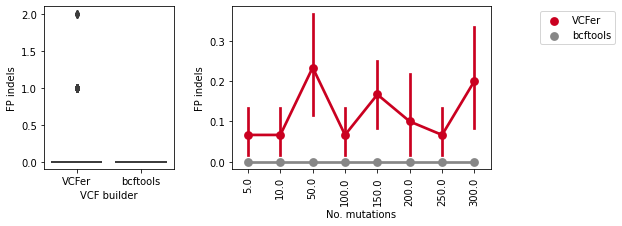

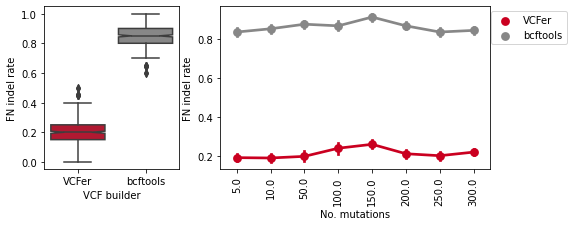

In [131]:
# plot FP sum for mutations and genomes
pallete_set = {
        'VCFer':'#ca0020','bcftools':'#878787','bcftools default':'#e0e0e0'}

if 'covid' not in folder:
    SNPsuball = pd.DataFrame()
    for genome in allgenome:
        SNPsub = SNP[SNP['Genome']==genome]
        # correct for FP diff location at 0 SNPs
        if True:
            SNPsub_0 = SNPsub[SNPsub['total_refSNP']==0].loc[:,['Tool VCF caller','FP_samePOS','FP_diffPOS']]
            SNPsub = SNPsub[SNPsub['total_refSNP']!=0]
            SNPsub = SNPsub.merge(SNPsub_0,left_on = 'Tool VCF caller',right_on = 'Tool VCF caller',how = 'left')
            SNPsub['FP']=SNPsub['FP_diffPOS_x']-SNPsub['FP_diffPOS_y']
            SNPsub.loc[SNPsub['FP']<0,'FP'] =0
            SNPsuball = SNPsuball.append(SNPsub)
    SNP = SNPsuball
    SNP = SNP.sort_values(['Genome','Tool','VCF caller','total_refSNP'])
    SNP['total_refSNP']=['%.0e'%(x) for x in SNP['total_refSNP']]
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)

    sns.pointplot(x='total_refSNP', y='FP', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FP indels')
    axs[0].get_legend().remove()
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    sns.boxplot(x='Genome', y='FP', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FP indels')
    axs[1].get_legend().remove()

    plt.savefig('%s/Figure 2a.pdf'%(folder))
    # FN sum
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)
    sns.pointplot(x='total_refSNP', y='FNrate', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FN indel rate')
    #axs[0].set(yscale="log")
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    sns.boxplot(x='Genome', y='FNrate', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FN indel rate')
    #axs[1].set(yscale="log")
    axs[1].get_legend().remove()
    plt.savefig('%s/Figure 2b.pdf'%(folder))
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('VCF builder') 
    axs.set_ylabel('FP indels')
    axs.get_legend().remove()
    plt.xticks(rotation=90)

    plt.savefig('%s/Figure 2c.pdf'%(folder),bbox_inches='tight')
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FNrate',notch = True,  data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('VCF builder') 
    axs.set_ylabel('FN indel rate')
    axs.get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 2d.pdf'%(folder),bbox_inches='tight')
    SNP = SNP[SNP['total_refSNP']!=0]
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Tool-VCF builder') 
    axs.set_ylabel('FP indels')
    axs.get_legend().remove()
    plt.xticks(rotation=90)

    plt.savefig('%s/Figure S2c.pdf'%(folder),bbox_inches='tight')
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FNrate',notch = True,  data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Tool-VCF builder') 
    axs.set_ylabel('FN indel rate')
    axs.get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure S2d.pdf'%(folder),bbox_inches='tight')
    SNP = SNP[SNP['total_refSNP']!=0]
else:
    SNP['sampleshort']=[x.split('.')[0] + '.' + x.split('.SNP')[1].split('.')[0] for x in SNP['Sample']]
    allgenome = SNP['sampleshort'].unique()
    SNPsuball = pd.DataFrame()
    for genome in allgenome:
        SNPsub = SNP[SNP['sampleshort']==genome]
        # correct for FP diff location at 0 SNPs
        if True:
            SNPsub_0 = SNPsub[SNPsub['total_refSNP']==0].loc[:,['Tool','FP_samePOS','FP_diffPOS']]
            SNPsub = SNPsub[SNPsub['total_refSNP']!=0]
            SNPsub = SNPsub.merge(SNPsub_0,left_on = 'Tool',right_on = 'Tool',how = 'left')
            SNPsub['FP']=SNPsub['FP_diffPOS_x']-SNPsub['FP_diffPOS_y']
            SNPsub.loc[SNPsub['FP']<0,'FP'] =0
            SNPsuball = SNPsuball.append(SNPsub)
    SNP = SNPsuball
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.3)
    sns.boxplot(x='VCF caller', y='FP', notch = True, data=SNPsuball,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('VCF builder') 
    axs[0].set_ylabel('FP indels')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FP', data=SNPsuball,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FP indels')
    plt.sca(axs[1])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.5, 1.0))
    plt.savefig('%s/Figure 4a.pdf'%(folder),bbox_inches='tight')
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(8,3),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.2)
    sns.boxplot(x='VCF caller', y='FNrate',notch = True,  data=SNPsuball,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('VCF builder') 
    axs[0].set_ylabel('FN indel rate')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FNrate', data=SNPsuball,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FN indel rate')
    plt.sca(axs[1])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.savefig('%s/Figure 4b.pdf'%(folder),bbox_inches='tight')
    

In [132]:
# covid
print(sum(SNP.loc[SNP['VCF caller']=='bcftools','FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FP']),
      sum(SNP.loc[SNP['VCF caller']=='bcftools','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FN'])
     )

print('FP',np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FNrate'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FNrate'],[0.05,0.5,0.95]))
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools','FNrate'])
)


0.0 4.042156862745098
FP [0. 0. 1.] [0. 0. 0.]
FNrate [0.1 0.2 0.4] [0.7  0.85 1.  ]
KstestResult(statistic=0.10833333333333334, pvalue=0.007116362893127761)
KstestResult(statistic=1.0, pvalue=7.97155066643758e-288)


In [86]:
# MO
print(sum(SNP.loc[SNP['VCF caller']=='bcftools','FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FP']),
      sum(SNP.loc[SNP['VCF caller']=='bcftools','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FN'])
     )
print(sum(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VCFer'),'FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FP']),
     sum(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VCFer'),'FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VCFer','FN']))
print(sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools'),'FP'])/
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VCFer'),'FP']),
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools'),'FN'])/
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VCFer'),'FN'])
     )
print('FP',
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VCFer'),'FP'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools'),'FP'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
print('FNrate',
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VCFer'),'FNrate'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools'),'FNrate'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[SNP['VCF caller']=='VCFer','FNrate'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools','FNrate'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95]),
                 np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VCFer'),'FNrate'],[0.05,0.5,0.95]),

           np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools'),'FNrate'],[0.05,0.5,0.95]),
)
print(sum(SNP.loc[SNP['VCF caller']=='bcftools','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='bcftools default','FN']))


0.06422018348623854 4.327052118760916
0.9602446483180428 0.29129515580476145
1.2307692307692308 4.502594033722438
FP [0. 0. 0.] [0. 0. 0.] [0. 0. 2.] [0. 0. 0.] [0. 0. 1.]
FNrate [0.01 0.1  0.21] [0.02925 0.4575  0.92   ] [0.015 0.115 0.24 ] [0.035  0.555  0.9305] [0.0395 0.35   0.885 ] [0.105 0.195 0.315] [0.475 0.785 0.96 ]
1.240356239460371


In [129]:
SNPspecies = pd.DataFrame(SNP.groupby(['Genome','VCF caller'])['FNrate'].median())
SNPspecies.reset_index(inplace=True)
print(kstest(SNPspecies.loc[SNPspecies['VCF caller']=='VCFer','FNrate'],
      SNPspecies.loc[SNPspecies['VCF caller']=='bcftools','FNrate'])
)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,np.quantile(SNPspeciessub['FNrate'],[0.05,0.5,0.95]),np.mean(SNPspeciessub['FNrate']),np.std(SNPspeciessub['FNrate']))
    

KstestResult(statistic=1.0, pvalue=4.11353352529823e-05)
VCFer [0.085 0.11  0.184] 0.12277777777777778 0.03779411411487766
bcftools [0.259 0.525 0.87 ] 0.5288888888888889 0.22178289907246607
bcftools default [0.258 0.35  0.772] 0.43555555555555553 0.19221579950734258


<AxesSubplot:xlabel='VCF caller', ylabel='FNrate'>

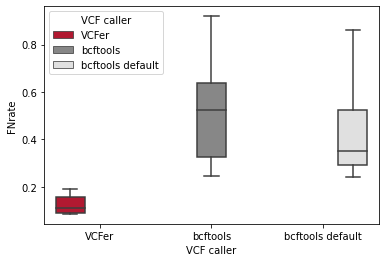

In [69]:
sns.boxplot(x='VCF caller', y='FNrate',  data=SNPspecies,hue = 'VCF caller',palette=pallete_set)


In [109]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools'),'FP'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VCFer'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VCFer'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VCFer'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VCFer'),'FP'])
)


KstestResult(statistic=0.026143790849673203, pvalue=0.9999996918694958)
KstestResult(statistic=0.0196078431372549, pvalue=0.9999999999999999)
KstestResult(statistic=0.09477124183006536, pvalue=0.31276082738565425)
KstestResult(statistic=0.1503267973856209, pvalue=0.06290475587594765)


In [110]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools'),'FNrate'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VCFer'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VCFer'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VCFer'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VCFer'),'FNrate'])
)

KstestResult(statistic=0.46405228758169936, pvalue=0.0)
KstestResult(statistic=0.10457516339869281, pvalue=0.3737884999691056)
KstestResult(statistic=0.7091503267973857, pvalue=0.0)
KstestResult(statistic=0.21568627450980393, pvalue=0.0015695383413527966)


In [128]:
# MO
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VCFer','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools','FNrate'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools','FNrate'])
)

KstestResult(statistic=0.06100217864923747, pvalue=0.36058842198699065)
KstestResult(statistic=0.7712418300653595, pvalue=8.175731397531392e-135)
KstestResult(statistic=0.02178649237472767, pvalue=0.999912557494621)
KstestResult(statistic=0.2222222222222222, pvalue=2.4285438915954945e-10)


In [2]:
# Time
folder = 'samtovcf/new/30thread/'
pallete_set = {
        'VCFer':'#ca0020','bcftools total':'#e0e0e0','bcftools only':'#878787'}

Time=pd.read_csv('%s/alltimesum.txt'%(folder), sep='\t')

Time['Genome']=[x.split('.')[0] for x in Time['fasta']]

genome_set = {'am_BA_g0003':'BiAd',
                 'am_BaFr_g0050':'BaFr',
                 'am_BaSa_g0015':'BaSa',
             'am_AkMu_g0002':'AkMu','am_BaOv_g0001':'BaOv',
              'am_BaVu_g0002':'BaVu','am_EsCo_g0005':'EsCo',
             'am_PaDi_g0001':'PaDi','SRR2842672':'human',
             'aa_BaFa_g0001':'BaFa-aa','bf_BaFa_g0001':'BaFa',
              'bj_EsCo_g0001':'EsCo','cx_BaXy_g0001':'BaXy','SRR10971381':'SARS-COV-2'}
Time['Genome'] = [genome_set[x] for x in Time['Genome']]
allgenome = Time['Genome'].unique()
Time['Tool'] = Time['tool']
print(Time['Tool'].unique())
Time['VCF caller']=[x.replace('Variant identifier','VCFer').replace('(',
                                                                  '').replace(')',
                                                                  '') for x in Time['VCF caller']]
Time = Time.sort_values(['Genome','Tool','VCF caller','SNP'])
print(Time['Tool'].unique(),Time['VCF caller'].unique())
print(allgenome)
Time['Tool VCF caller'] = Time['Tool'] + '-' + Time['VCF caller']
Time['SNP']=['%.0e'%(x) for x in Time['SNP']]
Time.head()


['bowtie2' 'minimap2' 'bwa']
['bowtie2' 'bwa' 'minimap2'] ['VCFer' 'bcftools only' 'bcftools total']
['BaXy' 'EsCo' 'AkMu' 'BaFr' 'PaDi' 'BaVu' 'BaFa' 'BiAd' 'BaOv']


,fasta,SNP,tool,VCF caller,Total time,Genome,Tool,Tool VCF caller
1206,am_AkMu_g0002,1e-06,bowtie2,VCFer,10.41,AkMu,bowtie2,bowtie2-VCFer
1518,am_AkMu_g0002,2e-06,bowtie2,VCFer,10.15,AkMu,bowtie2,bowtie2-VCFer
1071,am_AkMu_g0002,3e-06,bowtie2,VCFer,10.49,AkMu,bowtie2,bowtie2-VCFer
1335,am_AkMu_g0002,4e-06,bowtie2,VCFer,11.66,AkMu,bowtie2,bowtie2-VCFer
1185,am_AkMu_g0002,5e-06,bowtie2,VCFer,10.30,AkMu,bowtie2,bowtie2-VCFer


In [3]:
# samfile size
filesize = pd.read_csv('%s/../samsize.txt'%(folder),sep='\t',header=None)
filesize.columns=['sam size','file']
filesize['file']=[x.replace('.fasta','').replace('.SNP','').replace('.corrected','').replace('.sam','').replace('minimap','minimap2').replace('bowtie','bowtie2') for x in filesize['file']]
Time['file']=Time['fasta'] + '.' + [str(x) for x in Time['SNP']] + '.' + Time['Tool']
Time = Time.merge(filesize,left_on = 'file',right_on = 'file',how='left')
Time['sam size'] = [int(x)/1e6 for x in Time['sam size']]
Time.head()


,fasta,SNP,tool,VCF caller,Total time,Genome,Tool,Tool VCF caller,file,sam size
0,am_AkMu_g0002,1e-06,bowtie2,VCFer,10.41,AkMu,bowtie2,bowtie2-VCFer,am_AkMu_g0002.1e-06.bowtie2,2827.039285
1,am_AkMu_g0002,2e-06,bowtie2,VCFer,10.15,AkMu,bowtie2,bowtie2-VCFer,am_AkMu_g0002.2e-06.bowtie2,2827.070182
2,am_AkMu_g0002,3e-06,bowtie2,VCFer,10.49,AkMu,bowtie2,bowtie2-VCFer,am_AkMu_g0002.3e-06.bowtie2,2827.009534
3,am_AkMu_g0002,4e-06,bowtie2,VCFer,11.66,AkMu,bowtie2,bowtie2-VCFer,am_AkMu_g0002.4e-06.bowtie2,2827.028066
4,am_AkMu_g0002,5e-06,bowtie2,VCFer,10.30,AkMu,bowtie2,bowtie2-VCFer,am_AkMu_g0002.5e-06.bowtie2,2827.060077


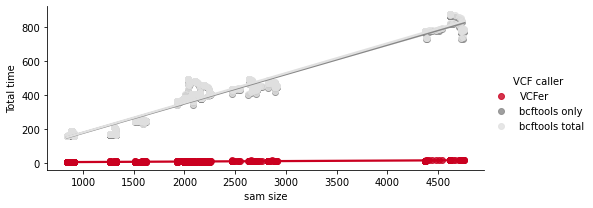

In [6]:
pallete_set = {
        'VCFer':'#ca0020','bcftools total':'#e0e0e0','bcftools only':'#878787'}

sns.lmplot(x='sam size', y='Total time', data=Time,
            hue = 'VCF caller',palette=pallete_set,height=3, aspect=7/3)
plt.savefig('%s/Figure Sam.pdf'%(folder))


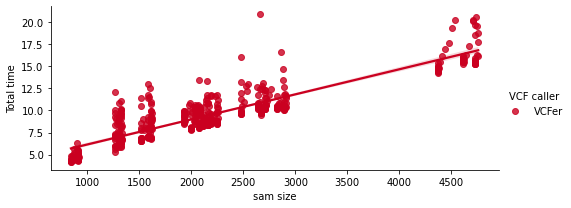

In [7]:
sns.lmplot(x='sam size', y='Total time', data=Time[Time['VCF caller']=='VCFer'],
            hue = 'VCF caller',palette=pallete_set,height=3, aspect=7/3)


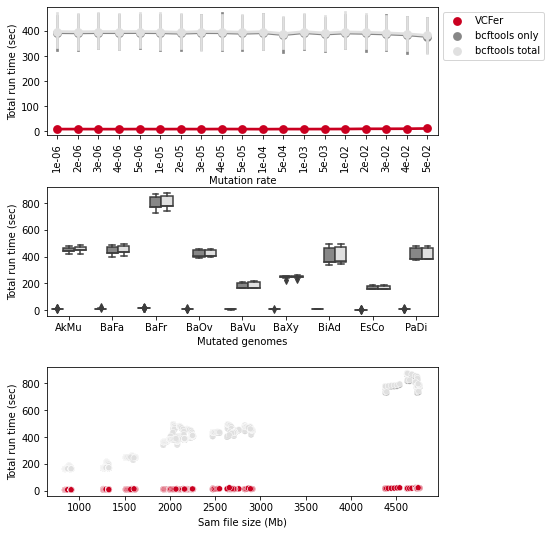

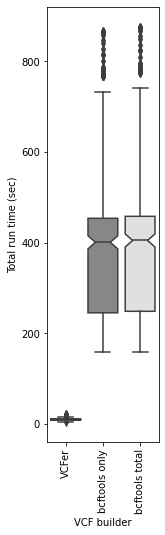

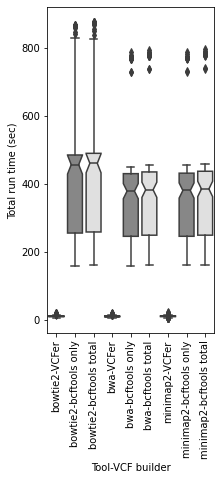

In [33]:
fig, axs = plt.subplots(nrows=3,ncols = 1,figsize=(7, 9))
plt.subplots_adjust(hspace=0.4)
sns.pointplot(x='SNP', y='Total time', data=Time,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
axs[0].set_xlabel('Mutation rate') 
axs[0].set_ylabel('Total run time (sec)')
axs[0].get_legend().remove()
plt.sca(axs[0])
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 1.0))

sns.boxplot(x='Genome', y='Total time', data=Time,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
axs[1].set_xlabel('Mutated genomes') 
axs[1].set_ylabel('Total run time (sec)')
axs[1].get_legend().remove()

sns.scatterplot(x='sam size', y='Total time', data=Time,
            ax=axs[2],hue = 'VCF caller',palette=pallete_set)
axs[2].set_xlabel('Sam file size (Mb)') 
axs[2].set_ylabel('Total run time (sec)')
axs[2].get_legend().remove()
plt.savefig('%s/Figure 1a.pdf'%(folder))

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 8))
sns.boxplot(x='VCF caller', y='Total time',notch = True,  data=Time,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
axs.set_xlabel('VCF builder') 
axs.set_ylabel('Total run time (sec)')
axs.get_legend().remove()
plt.xticks(rotation=90)
plt.savefig('%s/Figure 1b.pdf'%(folder),bbox_inches='tight')

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
sns.boxplot(x='Tool VCF caller', y='Total time', notch = True, data=Time,ax=axs,hue = 'VCF caller',dodge=False,palette = pallete_set)
axs.set_xlabel('Tool-VCF builder') 
axs.set_ylabel('Total run time (sec)')
plt.xticks(rotation=90)
axs.get_legend().remove()
plt.savefig('%s/Figure S4.pdf'%(folder),bbox_inches='tight')


In [114]:
#1 thread
print('Time',np.quantile(Time.loc[Time['VCF caller']=='VCFer','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools total','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools only','Total time'],[0.05,0.5,0.95]))
print(sum(Time.loc[Time['VCF caller']=='bcftools total','Total time'])/
      sum(Time.loc[Time['VCF caller']=='VCFer','Total time']),
      sum(Time.loc[Time['VCF caller']=='bcftools only','Total time'])/
      sum(Time.loc[Time['VCF caller']=='VCFer','Total time'])
     )

Time [15.292 35.14  66.016] [172.1  434.61 844.95] [159.3   399.19  771.192]
11.97293762409454 10.94887551769086


In [117]:
#30 thread
print('Time',np.quantile(Time.loc[Time['VCF caller']=='VCFer','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools total','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools only','Total time'],[0.05,0.5,0.95]))
print(sum(Time.loc[Time['VCF caller']=='bcftools total','Total time'])/
      sum(Time.loc[Time['VCF caller']=='VCFer','Total time']),
      sum(Time.loc[Time['VCF caller']=='bcftools only','Total time'])/
      sum(Time.loc[Time['VCF caller']=='VCFer','Total time'])
     )

Time [ 4.544  9.56  15.798] [162.022 404.77  782.764] [160.168 400.64  773.568]
40.89512817712187 40.43101453496606


In [118]:
# 30 thread
print(kstest(Time.loc[Time['VCF caller']=='VCFer','Total time'],
      Time.loc[Time['VCF caller']=='bcftools total','Total time'])
)


KstestResult(statistic=1.0, pvalue=1.116847523521345e-307)


In [115]:
# 1 thread
print(kstest(Time.loc[Time['VCF caller']=='VCFer','Total time'],
      Time.loc[Time['VCF caller']=='bcftools total','Total time'])
)

KstestResult(statistic=1.0, pvalue=1.116847523521345e-307)
